In [1]:
!git clone https://github.com/flyaflya/fsan830spring2025.git
%cd fsan830spring2025

fatal: destination path 'fsan830spring2025' already exists and is not an empty directory.
/content/fsan830spring2025


In [2]:
%cd fsan830spring2025

/content/fsan830spring2025/fsan830spring2025


In [3]:
!pip install -U numpy pymc pymc-bart arviz xarray matplotlib scikit-learn

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached pymc-5.22.0-py3-none-any.whl.metadata (16 kB)
  Using cached pytensor-2.30.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10.0 kB)


In [4]:
import pymc, pymc_bart
print("pymc version:", pymc.__version__)
print("pymc-bart version:", pymc_bart.__version__)

pymc version: 5.20.1
pymc-bart version: 0.9.0


In [5]:
import pandas as pd
import numpy as np
import pymc as pm
from pymc_bart import BART
from glob import glob
import os
import xml.etree.ElementTree as ET


In [6]:
# ====== 1. 批量解析 pastPerformanceData 特征 ======
def parse_past_performance(xml_path):
    import xml.etree.ElementTree as ET
    tree = ET.parse(xml_path)
    root = tree.getroot()
    records = []
    for race in root.findall('Race'):
        race_number = race.findtext('RaceNumber')
        # 遍历所有 Starters 节点
        for starters in race.findall('Starters'):
            # 针对每个马（即每个Starters下的字段）
            record = {'RaceNumber': race_number}
            # 逐字段判断并记录
            for item in starters:
                if item.tag == 'Horse':
                    record['HorseName'] = item.findtext('HorseName')
                    record['YearOfBirth'] = item.findtext('YearOfBirth')
                    record['FoalingArea'] = item.findtext('FoalingArea')
                elif item.tag in ['PostPosition', 'ProgramNumber', 'WeightCarried', 'Odds']:
                    record[item.tag] = item.text
                elif item.tag == 'Trainer':
                    record['Trainer'] = (item.findtext('LastName') or '') + (item.findtext('FirstName') or '')
                elif item.tag == 'Jockey':
                    record['Jockey'] = (item.findtext('LastName') or '') + (item.findtext('FirstName') or '')
            # 最基本的字段必须有，否则跳过
            if 'HorseName' in record and record['HorseName']:
                for k in record:
                    if isinstance(record[k], str):
                        record[k] = record[k].strip()
                records.append(record)
    return pd.DataFrame(records)

# ====== 2. 批量解析 resultsData 赛果 ======
def parse_results(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    records = []
    for race in root.findall('.//RACE'):
        race_number = race.get('NUMBER')
        for entry in race.findall('ENTRY'):
            record = {
                'RaceNumber': race_number,
                'HorseName': entry.findtext('NAME'),
                'OfficialFinish': entry.findtext('OFFICIAL_FIN'),
                'FinishTime': entry.findtext('FINISH_TIME'),
                'SpeedRating': entry.findtext('SPEED_RATING'),
                'DollarOdds': entry.findtext('DOLLAR_ODDS'),
            }
            for k in record:
                if isinstance(record[k], str):
                    record[k] = record[k].strip()
            records.append(record)
    return pd.DataFrame(records)

# ====== 3. 读取所有XML并合并 ======
pp_dir = 'data/rawDataForTraining/pastPerformanceData'
res_dir = 'data/rawDataForTraining/resultsData'

pp_files = glob(os.path.join(pp_dir, '*.xml'))
res_files = glob(os.path.join(res_dir, '*.xml'))

print(f"共发现PastPerformance xml: {len(pp_files)} 份，Result xml: {len(res_files)} 份")

pp_dfs = [parse_past_performance(f) for f in pp_files]
res_dfs = [parse_results(f) for f in res_files]

df_feat = pd.concat(pp_dfs, ignore_index=True)
df_label = pd.concat(res_dfs, ignore_index=True)

print("特征集 shape:", df_feat.shape, "标签集 shape:", df_label.shape)

# 主键统一处理为字符串去空格
for df in [df_feat, df_label]:
    df['HorseName'] = df['HorseName'].astype(str).str.lower().str.strip()
    df['RaceNumber'] = df['RaceNumber'].astype(str).str.strip()

# 合并
df_full = pd.merge(df_feat, df_label, on=['RaceNumber', 'HorseName'], how='inner', suffixes=('_pp', '_res'))
print("最终训练集 shape:", df_full.shape)

# 赔率处理（如有“5/2”样式需转成小数）
def odds_str_to_float(odds):
    if pd.isna(odds):
        return None
    try:
        return float(odds)
    except:
        if '/' in str(odds):
            try:
                num, den = odds.split('/')
                return float(num) / float(den)
            except:
                return None
        return None

df_full['Odds_float'] = df_full['Odds'].apply(odds_str_to_float)
df_full['DollarOdds'] = pd.to_numeric(df_full['DollarOdds'], errors='coerce')
df_full['OfficialFinish'] = pd.to_numeric(df_full['OfficialFinish'], errors='coerce')
df_full['FinishTime'] = pd.to_numeric(df_full['FinishTime'], errors='coerce')
df_full['SpeedRating'] = pd.to_numeric(df_full['SpeedRating'], errors='coerce')
df_full['WeightCarried'] = pd.to_numeric(df_full['WeightCarried'], errors='coerce')

# 保存
df_full.to_csv('final_supervised_training_set.csv', index=False)
print(df_full.head())
print("可用于建模的特征：", df_full.columns.tolist())

共发现PastPerformance xml: 18 份，Result xml: 18 份
特征集 shape: (1757, 10) 标签集 shape: (1482, 6)
最终训练集 shape: (1509, 14)
  RaceNumber        HorseName YearOfBirth FoalingArea PostPosition  \
0          1   george's honey        2021          KY            1   
1          1        honor cat        2021          KY            2   
2          1      deboisblanc        2021          KY            3   
3          1  sapphire nights        2021          KY            4   
4          1        unmatched        2021          KY            5   

  ProgramNumber  WeightCarried           Trainer               Jockey Odds  \
0             1            119         CasseMark       GutierrezReylu  5/1   
1             2            119  DiodoroRobertino       TorresCristian  8/1   
2             3            119           CoxBrad        LanderosChris  2/1   
3             4            119    AsmussenSteven  Santana, Jr.Ricardo  9/2   
4             5            112      ColebrookBen            NavasYoel  8/1  

In [7]:
# 自选特征（你可以用更多特征，建议先用Odds_float和WeightCarried测试）
feature_cols = ['Odds_float', 'WeightCarried', 'SpeedRating']  # 你可以增删
'''
feature_cols = [
    'YearOfBirth',
    'FoalingArea',
    'PostPosition',
    'WeightCarried',
    'Trainer',
    'Jockey',
    'SpeedRating',
    'Odds_float'
]
'''
X = df_full[feature_cols].fillna(0).values
y = df_full['OfficialFinish'].values


In [8]:

# 字段名和BRISNET字段对应的csv索引
column_indices = [
    2,    # RaceNumber
    44,   # HorseName
    45,   # YearOfBirth
    56,   # FoalingArea
    3,    # PostPosition
    42,   # ProgramNumber
    50,   # WeightCarried
    27,   # Trainer
    32,   # Jockey
    515,  # Odds (第一场历史比赛的赔率)
    615,  # OfficialFinish (第一场历史比赛的名次)
    1035, # FinishTime (第一场历史比赛的完赛时间)
    845,  # SpeedRating (第一场历史比赛的评分)
    43,   # DollarOdds
    # Odds_float 需要你自己用Odds列加工
]
# 只保留你需要的三个特征
feature_cols = ['Odds_float', 'WeightCarried', 'SpeedRating']

# 对应在BRISNET字典中的索引
column_indices = [
    515,  # Odds
    50,   # WeightCarried
    845   # SpeedRating
]

# 对应的列名（顺序要和上面索引一致）
columns = ['Odds', 'WeightCarried', 'SpeedRating']

# 读取原始测试集
X_test = pd.read_csv('data/rawDataForPrediction/CDX0426.csv', header=None, usecols=column_indices)
X_test.columns = columns

# 处理 Odds_float，只保留这三列
def odds_str_to_float(s):
    try:
        if pd.isna(s):
            return None
        if '-' in str(s):
            a, b = str(s).split('-')
            return float(a) / float(b)
        return float(s)
    except:
        return None

X_test['Odds_float'] = X_test['Odds'].apply(odds_str_to_float)

# 最终只保留 feature_cols
X_test_final = X_test[feature_cols]

print(X_test_final)

    Odds_float  WeightCarried  SpeedRating
0        118.0          17.21         81.0
1        118.0          14.10         73.0
2        118.0          33.57         57.0
3        118.0          49.95         64.0
4        113.0           8.45         79.0
..         ...            ...          ...
89       118.0           6.71         76.0
90       118.0           9.60         76.0
91       118.0          10.87         79.0
92       118.0         104.12         80.0
93       113.0           1.70         64.0

[94 rows x 3 columns]


In [18]:

with pm.Model() as model:
    μ = BART("μ", X, y)
    σ = pm.HalfNormal("σ", sigma=1.0)
    y_obs = pm.Normal("y_obs", mu=μ, sigma=σ, observed=y)
    trace = pm.sample(1000, tune=1000, target_accept=0.95, cores=1, random_seed=42)
    print("模型训练完毕！")


Output()

模型训练完毕！


1

In [19]:
assert μ.name == "μ", "BART 的 name 必须与你 predictions_input 的 key 一致"

In [23]:
import pymc as pm
from pymc_bart import BART
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from datetime import datetime

# --------------------------
# 1. 准备训练数据
# --------------------------
X_train = df_full[feature_cols].fillna(0).values
y_train = df_full['OfficialFinish'].values

# --------------------------
# 2. 训练 BART 模型
# --------------------------
with pm.Model() as model:
    μ = BART("μ", X_train, y_train)
    σ = pm.HalfNormal("σ", sigma=1.0)
    y_obs = pm.Normal("y_obs", mu=μ, sigma=σ, observed=y_train)

    trace = pm.sample(
        1000,
        tune=1000,
        target_accept=0.95,
        cores=1,
        random_seed=42,
        idata_kwargs={"log_likelihood": True}  # ✅ 确保 μ 会被记录进 trace
    )

print("✅ 模型训练完毕！")


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


✅ 模型训练完毕！


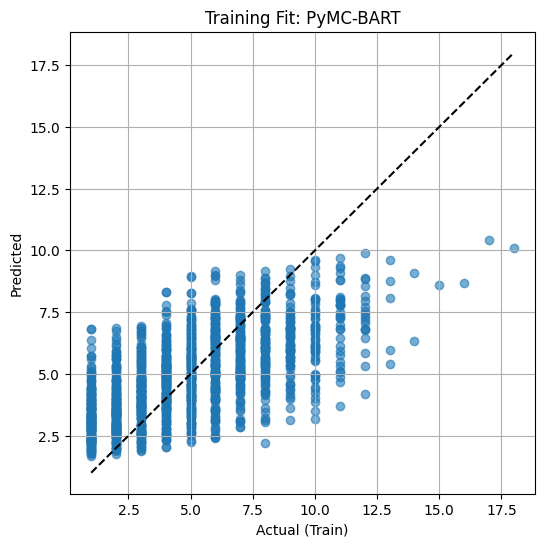

训练集 R² Score: 0.4221
训练集 RMSE: 2.21


In [24]:
# 从 trace.posterior 提取 μ 的后验均值（适用于训练集）
μ_train_mean = trace.posterior["μ"].mean(dim=("chain", "draw")).values

# 可视化训练拟合效果
plt.figure(figsize=(6, 6))
plt.scatter(y_train, μ_train_mean, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.xlabel("Actual (Train)")
plt.ylabel("Predicted")
plt.title("Training Fit: PyMC-BART")
plt.grid(True)
plt.show()

# 拟合性能指标（训练集）
r2 = r2_score(y_train, μ_train_mean)
rmse = np.sqrt(mean_squared_error(y_train, μ_train_mean))
print(f"训练集 R² Score: {r2:.4f}")
print(f"训练集 RMSE: {rmse:.2f}")


In [35]:
from datetime import datetime

def bart_train_and_predict(df_train, df_test_raw, feature_cols, target_col):
    # Step 0: 准备特征输入（从原始测试集中抽取特征用于模型，但保留完整字段用于输出）
    X_train = df_train[feature_cols].fillna(0).values
    y_train = df_train[target_col].values

    X_test = df_test_raw[feature_cols].fillna(0).values
    n_test = X_test.shape[0]

    # 拼接训练+测试输入，构造 dummy label 避免 nan
    X_all = np.vstack([X_train, X_test])
    y_all = np.concatenate([y_train, np.zeros(n_test)])

    # Step 1: 构建 PyMC 模型
    with pm.Model() as model:
        μ_all = BART("μ", X_all, y_all)
        σ = pm.HalfNormal("σ", sigma=1.0)

        # 训练集部分有 observed
        y_obs = pm.Normal("y_obs", mu=μ_all[:len(y_train)], sigma=σ, observed=y_train)

        # 测试集部分仅预测
        y_pred = pm.Normal("y_pred", mu=μ_all[len(y_train):], sigma=σ)

        # 训练模型
        trace = pm.sample(
            1000, tune=1000, target_accept=0.95, cores=1, random_seed=42
        )

        # Step 2: 后验预测（修复：禁止 inferencedata 返回）
        ppc = pm.sample_posterior_predictive(
            trace, var_names=["y_pred"], return_inferencedata=False
        )

    # Step 3: 整理预测结果（注意 reshape）
    y_pred_dist = ppc["y_pred"]  # shape: (n_chains, n_draws, n_test)
    y_pred_dist = y_pred_dist.reshape(-1, y_pred_dist.shape[-1])  # => (n_samples_total, n_test)

    if y_pred_dist.shape[1] != n_test:
        raise ValueError(f"预测维度异常: y_pred shape={y_pred_dist.shape}, 预期测试样本数={n_test}")

    y_pred_mean = y_pred_dist.mean(axis=0)
    y_pred_std = y_pred_dist.std(axis=0)

    # Step 4: 输出结果 DataFrame（保留完整测试字段）
    results_df = df_test_raw.reset_index(drop=True).copy()
    results_df["PredictedFinish"] = y_pred_mean
    results_df["PredictedStd"] = y_pred_std
    results_df["PredictedRank"] = results_df["PredictedFinish"].rank(method="min").astype(int)

    return results_df.sort_values("PredictedFinish").reset_index(drop=True)

In [39]:
# 设置特征列与目标列
feature_cols = ['Odds_float', 'WeightCarried', 'SpeedRating']
target_col = 'OfficialFinish'

# 执行训练 + 预测
results_df_sorted = bart_train_and_predict(df_full, X_test, feature_cols, target_col)

# 打印前几名预测
print("预测完成时间：", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print(results_df_sorted.head(10))




Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

预测完成时间： 2025-05-02 00:07:26
   Odds  WeightCarried  SpeedRating  Odds_float  PredictedFinish  \
0   118           1.00         93.0       118.0         5.903531   
1   124           0.63         90.0       124.0         6.094348   
2   118           4.80         88.0       118.0         6.159154   
3   123          18.20         93.0       123.0         6.199259   
4   118           1.90         91.0       118.0         6.200177   
5   123           6.10         88.0       123.0         6.255809   
6   125           4.90         85.0       125.0         6.257777   
7   118          18.60         85.0       118.0         6.385365   
8   125          11.20         83.0       125.0         6.419433   
9   123          13.62         86.0       123.0         6.427242   

   PredictedStd  PredictedRank  
0      2.257730              1  
1      2.369206              2  
2      2.318121              3  
3      2.316415              4  
4      2.351939              5  
5      2.292494          

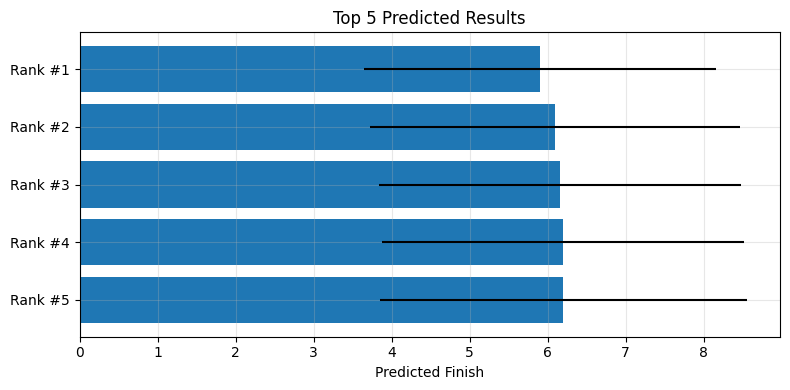

In [40]:
# 可视化前五名（不使用 HorseName）
top5 = results_df_sorted.head(5).copy()
top5_labels = [f"Rank #{i+1}" for i in range(len(top5))]

plt.figure(figsize=(8, 4))
plt.barh(top5_labels, top5["PredictedFinish"], xerr=top5["PredictedStd"])
plt.xlabel("Predicted Finish")
plt.title("Top 5 Predicted Results")
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
